In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from os import path
from sys import stdout

# interactive plots
# %matplotlib ipympl

In [3]:
import logging

logging.basicConfig(stream=stdout, level=logging.INFO, format='[%(levelname)s] %(message)s')
log = logging.getLogger()

In [4]:
csv_files = glob('Gyroscope*/Raw Data.csv')

trials = []
trials_meta = []

for file in csv_files:
    log.info(f"Processing '{file}' ...")
    data = pd.read_csv(file)
    datadir = path.dirname(file)

    # load time data
    time_data = pd.read_csv(path.join(datadir, 'meta/time.csv'))
    starts = time_data.loc[time_data['event'] == 'START', 'experiment time'].values
    pauses = time_data.loc[time_data['event'] == 'PAUSE', 'experiment time'].values

    # try to load segments data
    segments_file = path.join(datadir, 'meta/segments.csv')
    if path.isfile(segments_file):
        segments = pd.read_csv(segments_file)
    else:
        # no segments file => empty dataframe
        log.warning(f"cutoffs not found for '{datadir}'")
        segments = pd.DataFrame()

    # go through each segment of this file
    for i, (start, end) in enumerate(zip(starts, pauses)):
        # discard segments if specified
        if segments['keep'].values[i] == False:
            log.info(f'-> discarding segment {i}' )
            continue

        # if we have cutoff data, use it to crop the data
        # otherwise keep the whole segment
        if i in segments['segment'].values:
            start = segments.loc[i, 'start']
            end = segments.loc[i, 'end']

        mask = (data['Time (s)'] >= start) & (data['Time (s)'] <= end)
        trial = data.loc[mask]

        trials.append(trial)

        # get the comment if it exists
        comment = segments.loc[i, "comment"]
        if not pd.notna(comment): comment = None
        trials_meta.append((i, datadir, comment))

log.info(f'Found {len(trials)} trials in {len(csv_files)} files.')

[INFO] Processing 'Gyroscope rotation rate 2025-01-16 17-03-03/Raw Data.csv' ...
[INFO] Processing 'Gyroscope rotation rate 2025-01-16 17-10-11/Raw Data.csv' ...
[INFO] -> discarding segment 0
[INFO] Found 7 trials in 2 files.


[INFO] Trial 1: source 'Gyroscope rotation rate 2025-01-16 17-03-03' #0
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

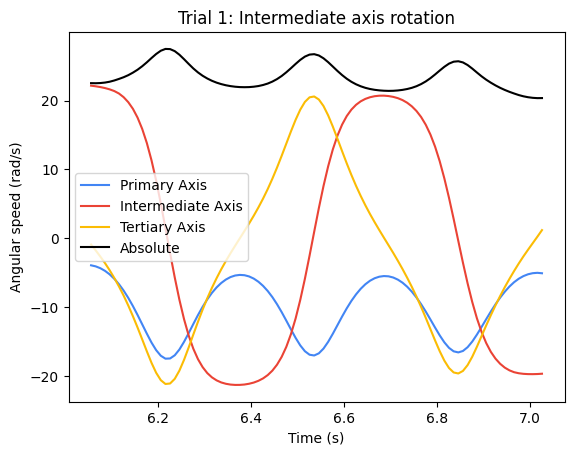

[INFO] Trial 2: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #1
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

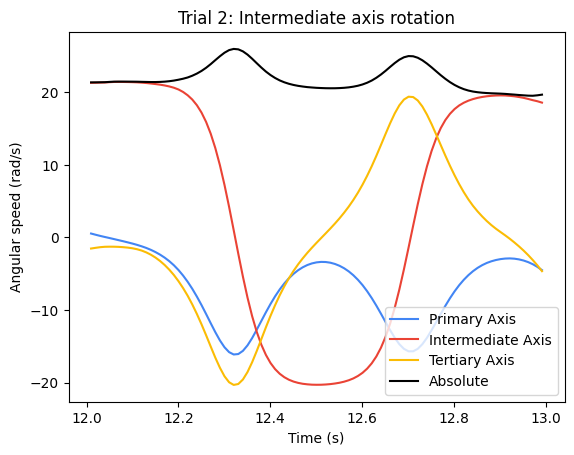

[INFO] Trial 3: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #2
[INFO] Comment: Tertiary axis rotation


<Figure size 640x480 with 0 Axes>

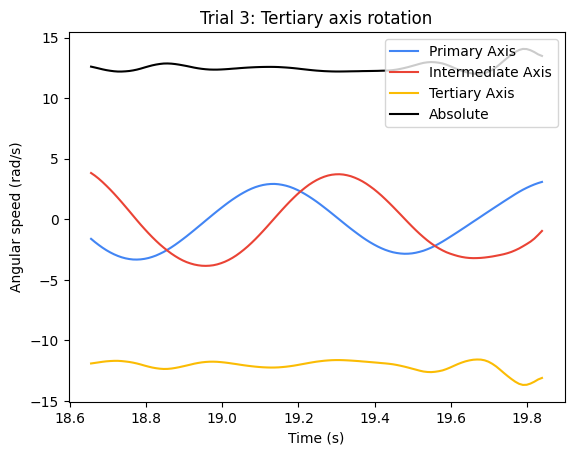

[INFO] Trial 4: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #3
[INFO] Comment: Primary axis rotation


<Figure size 640x480 with 0 Axes>

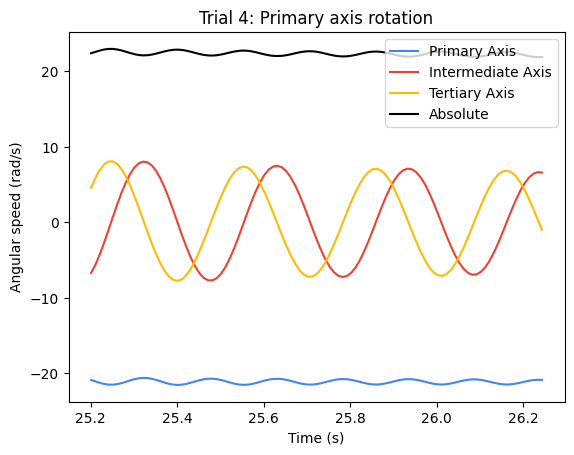

[INFO] Trial 5: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #4
[INFO] Comment: Tertiary axis rotation


<Figure size 640x480 with 0 Axes>

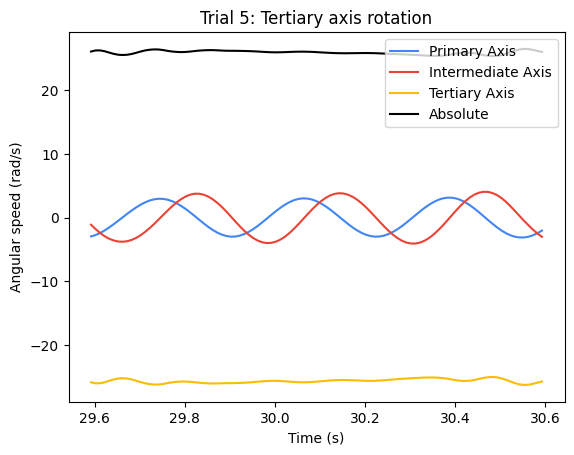

[INFO] Trial 6: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #5
[INFO] Comment: Intermediate axis rotation


<Figure size 640x480 with 0 Axes>

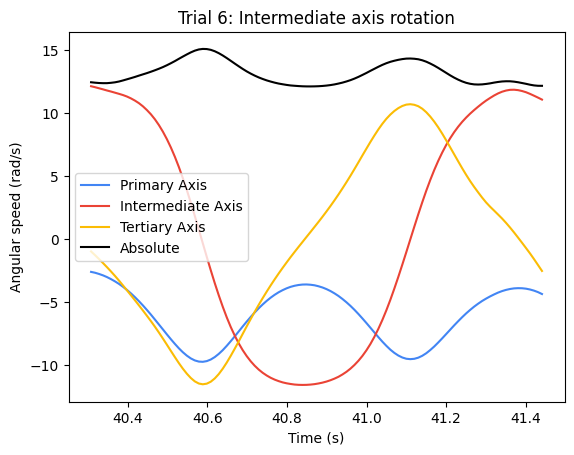

[INFO] Trial 7: source 'Gyroscope rotation rate 2025-01-16 17-10-11' #6
[INFO] Comment: Fast intermediate axis rotation


<Figure size 640x480 with 0 Axes>

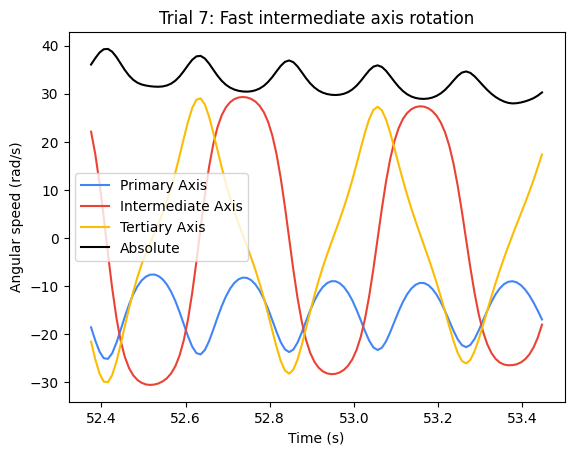

In [4]:
def plot_trial(trial, title):
    plt.figure()
    ax = trial.plot(
        x='Time (s)',
        y=[
            'Gyroscope z (rad/s)',
            'Gyroscope x (rad/s)',
            'Gyroscope y (rad/s)',
            'Absolute (rad/s)'
        ],
        color=['#4285f4', '#ea4335', '#fbbc04', 'black']
    )
    ax.legend([
        'Primary Axis',
        'Intermediate Axis',
        'Tertiary Axis',
        'Absolute'
    ])
    ax.set_ylabel('Angular speed (rad/s)')
    plt.title(title)
    plt.show()

for i, trial in enumerate(trials):
    title = f'Trial {i+1}'

    # process metadata
    j, source, comment = trials_meta[i]
    log.info(f"Trial {i+1}: source '{source}' #{j}")
    if comment:
        log.info(f'Comment: {comment}')
        title = f'{title}: {comment}'

    # make a graph
    plot_trial(trial, title)

In [17]:
from scipy.fftpack import fft, fftfreq
import numpy as np
def FFT(trial):
    print(type(trial), trial.columns)
    intermediate_axis_vel = trial['Gyroscope x (rad/s)']

    N = len(intermediate_axis_vel)
    T = 1e-2  # Sample spacing, implies 100 Hz sampling rate

    yf = fft(intermediate_axis_vel.values)
    xf = fftfreq(N, T)[:N//2]  # Positive frequencies
    magnitudes = abs(yf[:N//2])  # Magnitude spectrum

    # Identify dominant frequency
    dominant_idx = np.argmax(magnitudes)
    dominant_freq = xf[dominant_idx]
    dominant_magnitude = magnitudes[dominant_idx]

    # Calculate peak-to-noise ratio
    noise_magnitudes = np.delete(magnitudes, dominant_idx)
    noise_level = np.mean(noise_magnitudes)
    peak_to_noise_ratio = dominant_magnitude / noise_level if noise_level != 0 else np.inf

    period = 1 / dominant_freq if dominant_freq != 0 else np.inf

    return dominant_freq, period, peak_to_noise_ratio


for trial in trials:
    if "Gyroscope x (rad/s)" in trial.columns:
        dominant_freq, period, peak_to_noise_ratio = FFT(trial)
        print(f"Dominant Frequency: {dominant_freq:.2f} Hz")
        print(f"Period: {period:.4f} seconds")
        print(f"Peak-to-Noise Ratio: {peak_to_noise_ratio:.2f}")
    else:
        print("No intermediate axis data found")
    

<class 'pandas.core.frame.DataFrame'> Index(['Time (s)', 'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)',
       'Gyroscope z (rad/s)', 'Absolute (rad/s)'],
      dtype='object')
Dominant Frequency: 2.04 Hz
Period: 0.4900 seconds
Peak-to-Noise Ratio: 16.46
<class 'pandas.core.frame.DataFrame'> Index(['Time (s)', 'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)',
       'Gyroscope z (rad/s)', 'Absolute (rad/s)'],
      dtype='object')
Dominant Frequency: 1.01 Hz
Period: 0.9900 seconds
Peak-to-Noise Ratio: 45.43
<class 'pandas.core.frame.DataFrame'> Index(['Time (s)', 'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)',
       'Gyroscope z (rad/s)', 'Absolute (rad/s)'],
      dtype='object')
Dominant Frequency: 1.68 Hz
Period: 0.5950 seconds
Peak-to-Noise Ratio: 20.49
<class 'pandas.core.frame.DataFrame'> Index(['Time (s)', 'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)',
       'Gyroscope z (rad/s)', 'Absolute (rad/s)'],
      dtype='object')
Dominant Frequency: 2.86 Hz
Period: 0.3500 seconds
Peak-to-Noi